In [2]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy

    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
    root_path = "/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

In [4]:
root_audios_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_audios.csv"
root_recorders_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_recorders.csv"
root_ai_Zamuro = f"{root}/Zamuro/AI_Caract/AI_Zamuro.csv"

audios = pd.read_csv(root_audios_Zamuro, index_col=0)
recorders = pd.read_csv(root_recorders_Zamuro, index_col=0)
df_ai = pd.read_csv(root_ai_Zamuro, index_col=0)
df_ai.dropna(inplace=True)
df_ai.set_index("file",inplace=True, drop=True)
df_ai.drop(columns=["Date"], inplace=True)
df_ai = df_ai.reset_index(drop=False)
df_ai.rename(columns={"file":"y"}, inplace=True)
y = df_ai.pop('y') 
df_ai['y'] = y 
df_ai['rain_FI'] = df_ai.index.map(audios['rain_FI'])

def combinar_nombre_ubicacion(row):
    return f"{row['field_number_PR']}_{row['Filename']}"

# Aplicando la función a cada fila del DataFrame para crear la nueva columna
audios['Filename_'] = audios.apply(combinar_nombre_ubicacion, axis=1)

audios.set_index("Filename_", inplace=True)

In [5]:
def extract_parts(row):
    parts = row.split('_')
    location = parts[0]
    date = parts[1]
    time = parts[2].split('.')[0]  # Eliminar la extensión .WAV
    day = date[-2:]  # Últimos dos caracteres para el día
    hour = time[:2]
    return pd.Series([location, day, hour])

# Aplicar la función a la columna 'y' y crear nuevas columnas
df_ai[['location', 'day', 'hour']] =df_ai['y'].apply(extract_parts)

def define_hour_stage(hour):
    hour = int(hour)
    if 5 <= hour <= 8:
        return 'morning'
    elif 9 <= hour <= 16:
        return 'day'
    else:
        return 'night'

df_ai['hour_stage'] =df_ai['hour'].apply(define_hour_stage)
df_ai.set_index("y", inplace=True, drop=False)
df_ai['cover'] = df_ai.index.map(audios['cover'])
df_ai = df_ai[df_ai['rain_FI'] == 'NO']
df_ai = df_ai.dropna()

In [61]:
df_ai.to_csv('df_ai.csv', index=False) 


,ZCR,MEANt,VARt,SKEWt,KURTt,LEQt,BGNt,SNRt,MED,Ht,...,RAOQ,AGI,ROItotal,ROIcover,rain_FI,location,day,hour,hour_stage,cover
y,,,,,,,,,,,,,,,,,,,,,
RZUA01_20220903_104500.WAV,33413.633333,6.052836e-19,0.000803,0.463214,125.785312,62.065186,-25.232251,3.907083,0.054750,0.854772,...,0.317710,1.371307,699,11.697134,NO,RZUA01,3,10,day,pasture
RZUA01_20220903_113000.WAV,27640.366667,-7.398017e-19,0.002167,0.046234,22.329493,66.379409,-17.784118,2.163875,0.129061,0.940839,...,0.297566,1.288866,522,1.293209,NO,RZUA01,3,11,day,pasture
RZUA01_20220903_114500.WAV,30457.066667,1.426097e-18,0.008934,0.011160,11.288357,72.530919,-11.185479,1.877146,0.275884,0.961699,...,0.286141,1.358705,1213,0.604688,NO,RZUA01,3,11,day,pasture
RZUA01_20220903_180000.WAV,26602.833333,6.055727e-19,0.000455,0.048461,103.370373,59.598129,-26.396262,4.286802,0.047884,0.847441,...,0.381408,1.367189,1714,5.867066,NO,RZUA01,3,18,night,pasture
RZUA01_20220903_181500.WAV,16407.600000,-5.003039e-19,0.000985,0.080386,17.124613,62.954323,-22.284621,1.648931,0.076872,0.933467,...,0.151191,1.304565,1809,4.308646,NO,RZUA01,3,18,night,pasture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RZUH13_20220912_070000.WAV,37127.500000,2.395268e-19,0.000028,-0.123534,4.308900,47.563859,-36.848782,0.656902,0.014373,0.986157,...,0.384166,1.213904,1877,0.920458,NO,RZUH13,12,7,morning,pasture
RZUH13_20220912_071500.WAV,42607.800000,-5.329456e-21,0.000021,-0.147668,3.495183,46.161754,-37.072927,0.413386,0.014007,0.990583,...,0.473620,1.213884,1829,1.042269,NO,RZUH13,12,7,morning,pasture
RZUH13_20220912_073000.WAV,43009.266667,7.441964e-20,0.000019,-0.064865,4.044839,45.871403,-37.762048,0.553588,0.012939,0.988978,...,0.478226,1.217297,2570,1.936579,NO,RZUH13,12,7,morning,pasture


In [62]:
df_ai = pd.read_csv("New_df_ai.csv")

In [65]:
df_ai.set_index("y", inplace=True)

## All classification Covers

Accuracy: 0.8211168465509151
f1: 0.770372840418049
recall 0.7460020569923652
[[0.12848428 0.04974191 0.02130455]
 [0.01304552 0.5468794  0.01210699]
 [0.02327546 0.05940873 0.14575317]]
[[1369  530  227]
 [ 139 5827  129]
 [ 248  633 1553]]


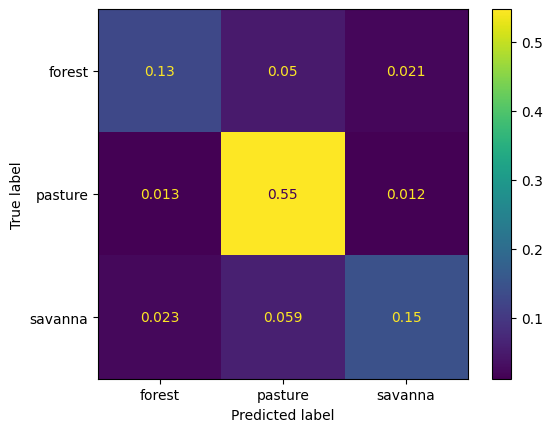

In [66]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns


X = np.asarray(df_ai.iloc[:,0:60])
y = np.asarray(df_ai.loc[:,"cover"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="all")
print(confusion_matrix_norm)
print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["forest", "pasture", "savanna"])
cm_display.plot()
plt.show()



## All classification Hours

Accuracy: 0.7858282496480525
f1: 0.6850521631884338
recall 0.6788444860224397
[[0.28615673 0.01126232 0.03913656]
 [0.06513374 0.04542468 0.05152511]
 [0.03754106 0.00957297 0.45424683]]
[[3049  120  417]
 [ 694  484  549]
 [ 400  102 4840]]


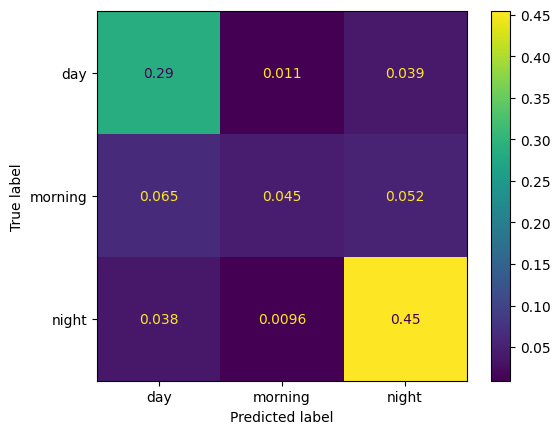

In [90]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns


X = np.asarray(df_ai.iloc[:,0:60])
y = np.asarray(df_ai.loc[:,"hour_stage"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="all")
print(confusion_matrix_norm)
print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["day", "morning", "night"])
cm_display.plot()
plt.show()

In [53]:
set(y_pred_rf)
a=0
for i in range(len(y_pred_rf)):
    if y_pred_rf[i] == "savanna":
        a+=1
        
print(a)

2175


## Cover classification

In [78]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

accuracies_ai_cover = []
f1_scores_ai_cover = []
recalls_ai_cover = []
df_day={}
for i in ["03","04","05","06","07","08","09","10","11","12","13"]:
    df_day = df_ai[df_ai['day'].isin([int(i)])]
    X = np.asarray(df_day.iloc[:,0:60])
    y = np.asarray(df_day.loc[:,"cover"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_ai_cover.append(accuracy)
    f1_scores_ai_cover.append(f1_score)
    recalls_ai_cover.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ai_covers.npy", accuracies_ai_cover)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ai_covers.npy", f1_scores_ai_cover)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ai_covers.npy", recalls_ai_cover)

Accuracy: 0.7951807228915663
f1: 0.6782271415732463
recall 0.6546546546546547
Accuracy: 0.8004895960832313
f1: 0.7060812773090731
recall 0.6687646485234935
Accuracy: 0.7845433255269321
f1: 0.7286169791890615
recall 0.7072773872681842
Accuracy: 0.7721345229924502
f1: 0.7097488812566931
recall 0.6874872660593182
Accuracy: 0.774015203870076
f1: 0.7174498426522252
recall 0.6834890416492968
Accuracy: 0.7832167832167832
f1: 0.712888869044635
recall 0.6839863920782455
Accuracy: 0.7998046875
f1: 0.7476060928809954
recall 0.7292098934860052
Accuracy: 0.8102325581395349
f1: 0.7609228669904354
recall 0.7439021755791942
Accuracy: 0.8078291814946619
f1: 0.7569848533602679
recall 0.7257741252027105
Accuracy: 0.8099173553719008
f1: 0.7291228653526151
recall 0.6981461198328668
Accuracy: 0.8304347826086956
f1: 0.7225585527733892
recall 0.6778379540081668


## Hour Stage Classification

In [80]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

accuracies_ai_hour = []
f1_scores_ai_hour = []
recalls_ai_hour = []
df_day={}
for i in ["03","04","05","06","07","08","09","10","11","12","13"]:
    df_day = df_ai[df_ai['day'].isin([int(i)])]
    X = np.asarray(df_day.iloc[:,0:60])
    y = np.asarray(df_day.loc[:,"hour_stage"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_ai_hour.append(accuracy)
    f1_scores_ai_hour.append(f1_score)
    recalls_ai_hour.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ai_hours.npy", accuracies_ai_hour)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ai_hours.npy", f1_scores_ai_hour)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ai_hours.npy", recalls_ai_hour)

Accuracy: 0.8554216867469879
f1: 0.5227434257285003
recall 0.515542328042328
Accuracy: 0.8200734394124847
f1: 0.738572082614526
recall 0.7091168045145171
Accuracy: 0.7540983606557377
f1: 0.6509567584089131
recall 0.6460710390461116
Accuracy: 0.8236101578586136
f1: 0.7556419999617555
recall 0.7475075653940223
Accuracy: 0.8237733241188666
f1: 0.7557357931053494
recall 0.74799570315067
Accuracy: 0.7987567987567987
f1: 0.7391735905420117
recall 0.7301345099443286
Accuracy: 0.794921875
f1: 0.7008750827411464
recall 0.684946574999341
Accuracy: 0.7702325581395348
f1: 0.6380517288695859
recall 0.6263610244700425
Accuracy: 0.8051601423487544
f1: 0.7432150387670099
recall 0.7308435217916306
Accuracy: 0.8140495867768595
f1: 0.782438155779931
recall 0.7774052788420605
Accuracy: 0.7869565217391304
f1: 0.7388132692270902
recall 0.7193716397849462
